## 1. Build Regression Model with TF DenseFeatures

### Overview
- Used preprocessed dataset from TF regression tutorial https://www.tensorflow.org/tutorials/keras/regression
- Used TF feature column API and TF DenseFeatures instead of the methods used in tutorial

### Dataset Preprocessing From Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
raw_dataset.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'ModelYear', 'Origin']
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [7]:
#split 80 20 train test split
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
train_dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear', 'Origin'],
      dtype='object')

In [9]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
146,28.0,4,90.0,75.0,2125.0,14.5,74,USA
282,22.3,4,140.0,88.0,2890.0,17.3,79,USA
69,12.0,8,350.0,160.0,4456.0,13.5,72,USA
378,38.0,4,105.0,63.0,2125.0,14.7,82,USA
331,33.8,4,97.0,67.0,2145.0,18.0,80,Japan


In [10]:
train_labels = train_dataset['MPG']

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
ModelYear,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [12]:
categorical_feature_list = ['Origin']
# for the sake of this exercise treat Model Year and Cylinders as numerical but could process differently
numerical_feature_list = ['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear']

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset[numerical_feature_list])
normed_test_data = norm(test_dataset[numerical_feature_list])

In [14]:
norm_train_data = pd.concat([ train_dataset[categorical_feature_list + ['MPG']],  normed_train_data], 
                            axis=1, sort=False)
norm_test_data = pd.concat([ test_dataset[categorical_feature_list + ['MPG']], normed_test_data], axis=1, sort=False)

In [15]:
norm_train_data.to_csv("mpg_train_data.csv", index=False)
norm_test_data.to_csv("mpg_test_data.csv", index=False)

In [16]:
norm_train_data.head()

,Origin,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear
146,USA,28.0,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397
282,USA,22.3,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910
69,USA,12.0,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519
378,USA,38.0,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094
331,Japan,33.8,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971


### Load Preprocessed Dataset

- Use TF Dataset API and Feature Column APIs instead

In [17]:
train_data = pd.read_csv("mpg_train_data.csv" )
test_data = pd.read_csv("mpg_test_data.csv" )

In [18]:
#adapted from https://www.tensorflow.org/tutorials/structured_data/feature_columns
def df_to_dataset(df, predictor,  batch_size=32):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [19]:
PREDICTOR_FIELD = 'MPG'
batch_size = 128
train_ds = df_to_dataset(train_data, PREDICTOR_FIELD, batch_size=batch_size)
test_ds = df_to_dataset(test_data, PREDICTOR_FIELD, batch_size=batch_size)

Metal device set to: Apple M1


2022-06-17 13:52:06.188865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-17 13:52:06.188977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
sample_batch = next(iter(train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

### Convert Origin Categorical Feature to One Hot Encoded Feature

In [21]:
# only feature 
v_list = tf.feature_column.categorical_column_with_vocabulary_list("Origin", 
                                                            train_data['Origin'].unique())
one_hot_origin_feature = tf.feature_column.indicator_column(v_list)

In [22]:
print("Example categorical field:\n{}".format(one_hot_origin_feature))
demo(one_hot_origin_feature, sample_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0))
tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [

### Create Numerical Features

NOTE: We do not use the normalizer function here because the dataset has already been normalized.

In [23]:
#convert numerical features, these features have already been normalized
def create_tf_numerical_feature_cols(numerical_col_list):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        tf_numeric_feature = tf.feature_column.numeric_column(
                    key=c,  dtype=tf.float64)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [24]:
tf_numerical_feature_list = create_tf_numerical_feature_cols(numerical_feature_list)

In [25]:
tf_numerical_feature_list

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [26]:
# take first numerical feature
test_cont_var1 = tf_numerical_feature_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, sample_batch)

Example continuous field:
NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)

tf.Tensor(
[[-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [ 0.30726957]
 [ 0.30726957]
 [ 1.4

### Combine TF Features with DenseFeatures

In [27]:
feature_columns = [ one_hot_origin_feature ] + tf_numerical_feature_list

In [28]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [29]:
dense_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [30]:
# Use same architecture as example
def build_model(dense_feature_layer):
    model = tf.keras.Sequential([
    dense_feature_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    

    return model

In [31]:
model = build_model(dense_feature_layer)

In [32]:
# validation split

In [33]:
# No validation set b/c need to build separate TF dataset
EPOCHS = 2000
# Set to patience to 100 so it trains to end of epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
history = model.fit(train_ds,   callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Epoch 1/2000
3/3 [==============================] - 0s 21ms/step - loss: 597.6130 - mae: 23.1158 - mse: 597.6130
Epoch 2/2000
1/3 [=========>....................] - ETA: 0s - loss: 570.2481 - mae: 22.3956 - mse: 570.2481

2022-06-17 13:52:06.569780: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-17 13:52:06.569926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 8ms/step - loss: 572.0781 - mae: 22.5222 - mse: 572.0781
Epoch 3/2000
3/3 [==============================] - 0s 9ms/step - loss: 551.6537 - mae: 22.0377 - mse: 551.6537
Epoch 4/2000
3/3 [==============================] - 0s 9ms/step - loss: 531.9891 - mae: 21.5635 - mse: 531.9891
Epoch 5/2000
3/3 [==============================] - 0s 9ms/step - loss: 512.4223 - mae: 21.0892 - mse: 512.4223
Epoch 6/2000
3/3 [==============================] - 0s 9ms/step - loss: 492.0709 - mae: 20.5968 - mse: 492.0709
Epoch 7/2000
3/3 [==============================] - 0s 8ms/step - loss: 470.5090 - mae: 20.0642 - mse: 470.5090
Epoch 8/2000
3/3 [==============================] - 0s 9ms/step - loss: 448.5177 - mae: 19.5112 - mse: 448.5177
Epoch 9/2000
3/3 [==============================] - 0s 9ms/step - loss: 425.8838 - mae: 18.9356 - mse: 425.8838
Epoch 10/2000
3/3 [==============================] - 0s 9ms/step - loss: 402.5907 - mae: 18.3272 - mse: 402.5907
Epoc

3/3 [==============================] - 0s 8ms/step - loss: 7.7115 - mae: 1.9916 - mse: 7.7115
Epoch 77/2000
3/3 [==============================] - 0s 8ms/step - loss: 7.5621 - mae: 1.9810 - mse: 7.5621
Epoch 78/2000
3/3 [==============================] - 0s 8ms/step - loss: 7.8323 - mae: 2.0133 - mse: 7.8323
Epoch 79/2000
3/3 [==============================] - 0s 8ms/step - loss: 7.6297 - mae: 1.9726 - mse: 7.6297
Epoch 80/2000
3/3 [==============================] - 0s 8ms/step - loss: 7.6006 - mae: 2.0028 - mse: 7.6006
Epoch 81/2000
3/3 [==============================] - 0s 8ms/step - loss: 7.4547 - mae: 1.9616 - mse: 7.4547
Epoch 82/2000
3/3 [==============================] - 0s 8ms/step - loss: 7.4394 - mae: 1.9525 - mse: 7.4394
Epoch 83/2000
3/3 [==============================] - 0s 8ms/step - loss: 7.4636 - mae: 1.9741 - mse: 7.4636
Epoch 84/2000
3/3 [==============================] - 0s 8ms/step - loss: 7.3753 - mae: 1.9770 - mse: 7.3753
Epoch 85/2000
3/3 [=======================

3/3 [==============================] - 0s 8ms/step - loss: 6.2187 - mae: 1.7734 - mse: 6.2187
Epoch 152/2000
3/3 [==============================] - 0s 8ms/step - loss: 6.3183 - mae: 1.7886 - mse: 6.3183
Epoch 153/2000
3/3 [==============================] - 0s 8ms/step - loss: 6.4779 - mae: 1.8365 - mse: 6.4779
Epoch 154/2000
3/3 [==============================] - 0s 8ms/step - loss: 6.2146 - mae: 1.7676 - mse: 6.2146
Epoch 155/2000
3/3 [==============================] - 0s 8ms/step - loss: 6.3027 - mae: 1.7758 - mse: 6.3027
Epoch 156/2000
3/3 [==============================] - 0s 19ms/step - loss: 6.2569 - mae: 1.7987 - mse: 6.2569
Epoch 157/2000
3/3 [==============================] - 0s 13ms/step - loss: 6.5601 - mae: 1.8438 - mse: 6.5601
Epoch 158/2000
3/3 [==============================] - 0s 8ms/step - loss: 6.2661 - mae: 1.7783 - mse: 6.2661
Epoch 159/2000
3/3 [==============================] - 0s 8ms/step - loss: 6.3548 - mae: 1.7847 - mse: 6.3548
Epoch 160/2000
3/3 [============

3/3 [==============================] - 0s 8ms/step - loss: 5.9533 - mae: 1.7306 - mse: 5.9533
Epoch 227/2000
3/3 [==============================] - 0s 8ms/step - loss: 5.9693 - mae: 1.7276 - mse: 5.9693
Epoch 228/2000
3/3 [==============================] - 0s 8ms/step - loss: 5.8360 - mae: 1.7287 - mse: 5.8360
Epoch 229/2000
3/3 [==============================] - 0s 8ms/step - loss: 5.7794 - mae: 1.7019 - mse: 5.7794
Epoch 230/2000
3/3 [==============================] - 0s 8ms/step - loss: 5.7808 - mae: 1.7009 - mse: 5.7808
Epoch 231/2000
3/3 [==============================] - 0s 8ms/step - loss: 5.7559 - mae: 1.7088 - mse: 5.7559
Epoch 232/2000
3/3 [==============================] - 0s 8ms/step - loss: 6.1341 - mae: 1.7663 - mse: 6.1341
Epoch 233/2000
3/3 [==============================] - 0s 8ms/step - loss: 5.7627 - mae: 1.6854 - mse: 5.7627
Epoch 234/2000
3/3 [==============================] - 0s 8ms/step - loss: 6.0443 - mae: 1.7647 - mse: 6.0443
Epoch 235/2000
3/3 [==============

In [34]:
loss, mae, mse = model.evaluate(test_ds, verbose=2)

1/1 - 0s - loss: 6.6241 - mae: 2.0119 - mse: 6.6241 - 106ms/epoch - 106ms/step


2022-06-17 13:52:13.682345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [35]:
test_labels = test_data[PREDICTOR_FIELD].values

1/1 [==============================] - 0s 61ms/step


2022-06-17 13:52:13.773800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


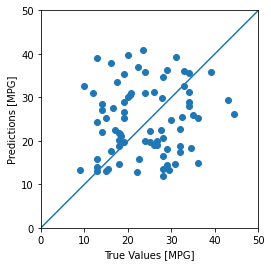

In [36]:
test_predictions = model.predict(test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


### Show Model Prediction Output

In [37]:
model_pred_outputs = {
    "pred": test_predictions,
    "actual_value": test_labels,
}
model_output_df = pd.DataFrame(model_pred_outputs)

In [38]:
model_output_df.head()

,pred,actual_value
0,13.050483,15.0
1,32.601101,10.0
2,13.249461,9.0
3,22.156273,25.0
4,28.970356,19.0


## 2. Model Evaluation 

### Preparing Regression Output for Binary Scoring Model Evaluation

- Create binary label for mileage prediction over 25 miles per gallon
    - 0 = Not Fuel Efficient, < 25 MPG
    - 1 = Fuel Efficient >= 25 MPG

In [39]:
# Convert Regression Output to binary classification output
model_output_df.head()

,pred,actual_value
0,13.050483,15.0
1,32.601101,10.0
2,13.249461,9.0
3,22.156273,25.0
4,28.970356,19.0


In [40]:
def convert_to_binary(df, pred_field, actual_field):
    df['score'] = df[pred_field].apply(lambda x: 1 if x>=25 else 0 )
    df['label_value'] = df[actual_field].apply(lambda x: 1 if x>=25 else 0)
    return df

In [41]:
binary_df = convert_to_binary(model_output_df, 'pred', 'actual_value')
binary_df.head()

,pred,actual_value,score,label_value
0,13.050483,15.0,0,0
1,32.601101,10.0,1,0
2,13.249461,9.0,0,0
3,22.156273,25.0,0,1
4,28.970356,19.0,1,0


### Classification Common Model Evaluation Metrics

In [42]:
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

In [43]:
print(classification_report(binary_df['label_value'], binary_df['score']))

              precision    recall  f1-score   support

           0       0.50      0.49      0.49        41
           1       0.45      0.46      0.45        37

    accuracy                           0.47        78
   macro avg       0.47      0.47      0.47        78
weighted avg       0.48      0.47      0.47        78



In [44]:
#F1
f1_score(binary_df['label_value'], binary_df['score'], average='weighted')

0.4746185501741057

In [45]:
#AUC - area under the ROC curve
roc_auc_score(binary_df['label_value'], binary_df['score'])

0.47363216875411995

### Brier Score

In [46]:
random_predictions = np.random.random((100))
random_predictions

array([0.65595543, 0.49216469, 0.6169028 , 0.8343313 , 0.68468579,
       0.22813098, 0.94574533, 0.16716997, 0.50976192, 0.33771689,
       0.47033633, 0.73179042, 0.06644197, 0.29664562, 0.47123347,
       0.43428578, 0.36994163, 0.95086452, 0.81262397, 0.19572715,
       0.5149353 , 0.73434858, 0.79468646, 0.60858413, 0.73025748,
       0.04930235, 0.66716603, 0.57412456, 0.10202704, 0.30981086,
       0.86595473, 0.38934216, 0.82054339, 0.99478301, 0.81617731,
       0.7586116 , 0.67020977, 0.85758923, 0.20495352, 0.36741039,
       0.65526134, 0.37868951, 0.67260635, 0.84322237, 0.8553951 ,
       0.92261623, 0.89210657, 0.39877732, 0.52227687, 0.03759873,
       0.53249844, 0.62422529, 0.43050966, 0.18143898, 0.63665001,
       0.73839128, 0.42732124, 0.46473458, 0.27364453, 0.2076966 ,
       0.61106677, 0.79916387, 0.47970249, 0.91896077, 0.57885254,
       0.08073765, 0.60988502, 0.51236183, 0.89271348, 0.9632373 ,
       0.81534492, 0.24584886, 0.56814281, 0.51998343, 0.01328

In [47]:
random_labels = np.random.choice([0, 1], 100)
random_labels

array([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1])

- Convert probability to binary predictions

In [48]:
probability_prediction_df = pd.DataFrame({"prob_prediction": random_predictions,
                "binary_prediction": np.array([ 1 if abs(x)>=0.5 else 0 for x in random_predictions], dtype=int),
                                "label": random_labels})

In [49]:
probability_prediction_df.head()

,prob_prediction,binary_prediction,label
0,0.655955,1,1
1,0.492165,0,1
2,0.616903,1,0
3,0.834331,1,0
4,0.684686,1,1


In [50]:
y_true = probability_prediction_df['label'].values 
y_pred = probability_prediction_df['binary_prediction'].values

In [51]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.57


In [52]:
bs_loss = brier_score_loss(y_true, probability_prediction_df['prob_prediction'])
print(bs_loss)

0.2719539941619691


### Misclassified

In [53]:
missclassified_df = probability_prediction_df[probability_prediction_df['binary_prediction']!=probability_prediction_df['label']]

<AxesSubplot:ylabel='Frequency'>

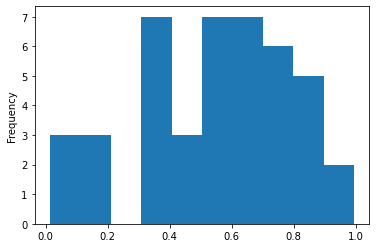

In [54]:
missclassified_df['prob_prediction'].plot(kind='hist')

## 3. Demographic Group Bias Analysis

- Select groups to analyze
- Prepare data 
- Analyze groups


### Select groups to analyze
- Selected 'origin' field which gives the country of origin for the car.

In [55]:
#combine binary df with original test df, order was not shuffled so can do

In [56]:
merged_binary_df = binary_df.assign(origin = test_data['Origin'].values)

In [57]:
merged_binary_df.head()

,pred,actual_value,score,label_value,origin
0,13.050483,15.0,0,0,USA
1,32.601101,10.0,1,0,USA
2,13.249461,9.0,0,0,USA
3,22.156273,25.0,0,1,Japan
4,28.970356,19.0,1,0,USA


### Prepare Data

In [58]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

In [59]:
ae_df, _ = preprocess_input_df(merged_binary_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

### Analyze Groups

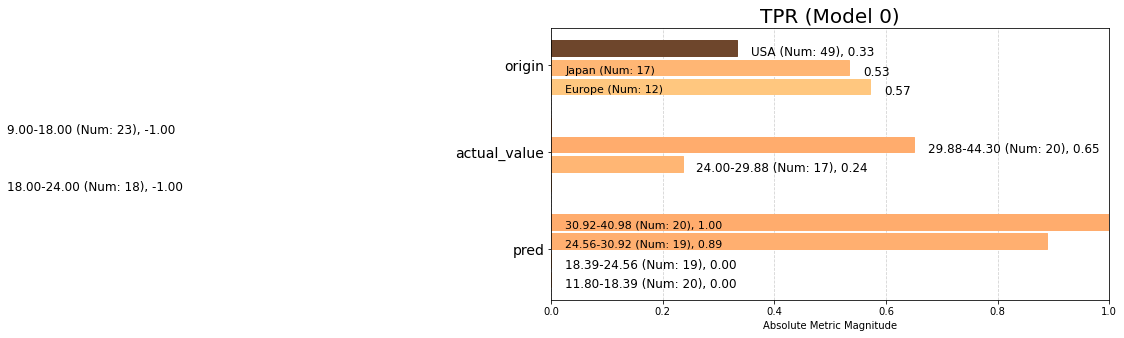

In [60]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.05)

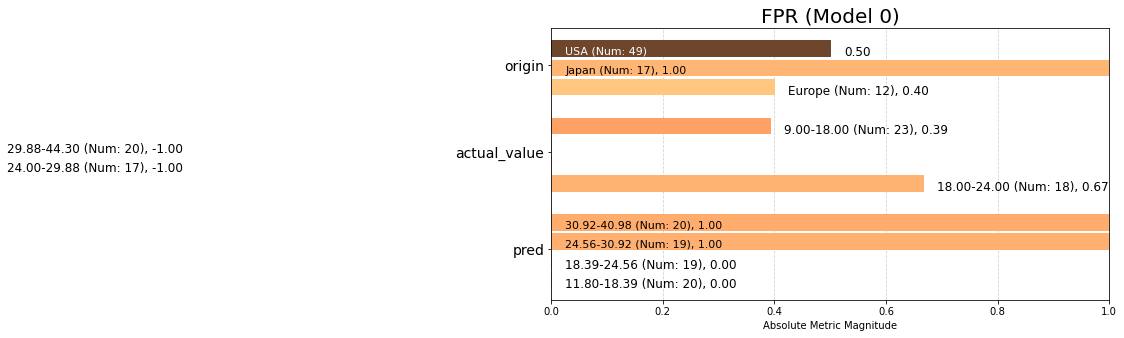

In [61]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr', min_group_size=0.05)

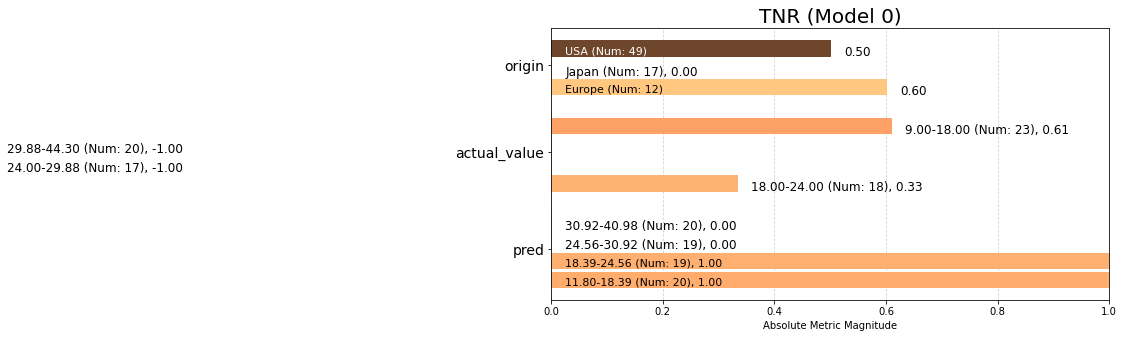

In [62]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.05)

In [63]:
# Bias Report - http://aequitas.dssg.io/audit/eg1cp7ku/adult_rf_binary/

## 4. Train Uncertainty Estimation Model with TF Probability

### Instructions
- Using MPG model from earlier, create uncertainty estimation model with TF Probability.
- In particular, we will focus on building a model that accounts for Aleatoric Uncertainty.

In [64]:
import tensorflow_probability as tfp

### Aleatoric Uncertainty
- Known Unknowns
- 2 Main Changes to our network 
    - Add a second unit to the last dense layer before passing it to Tensorflow Probability layer to model for the predictor y and the heteroscedasticity or unequal scattering of data
    - DistributionLambda distribution mean and std
- DistributionLambda is a special Keras layer that uses a Python lambda to construct a distribution based on the layer inputs and the output of the final layer of the model is passed into the loss function. Lastly. this model will return a distribution for both mean and standard deviation.

In [65]:
train_label_stats = train_labels.describe()
train_label_stats

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [66]:
def build_seq_prob_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(  
            lambda t:tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])

            )
         )
  
        
        
    ])
    return model

def build_prob_model(train_ds,   feature_layer,  epochs=5, loss_metric='mse'):
    model = build_seq_prob_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(tf.optimizers.Adam(learning_rate=0.05), loss=loss, metrics=[loss_metric])
    history = model.fit(train_ds, 
                        epochs=epochs)
    return model, history

### Train Probability Model

In [67]:
prob_model, history = build_prob_model(train_ds, dense_feature_layer,  epochs=500)

Epoch 1/500


2022-06-17 13:52:14.764774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 31ms/step - loss: 323.1413 - mse: 417.8982
Epoch 2/500
3/3 [==============================] - 0s 10ms/step - loss: 14.2126 - mse: 3455.4753
Epoch 3/500
3/3 [==============================] - 0s 9ms/step - loss: 13.8407 - mse: 15850.0352
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 9.2558 - mse: 20428.4238
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 6.6705 - mse: 17244.9102
Epoch 6/500
3/3 [==============================] - 0s 9ms/step - loss: 5.6139 - mse: 13330.7188
Epoch 7/500
3/3 [==============================] - 0s 9ms/step - loss: 5.3791 - mse: 9623.5508
Epoch 8/500
3/3 [==============================] - 0s 9ms/step - loss: 5.4984 - mse: 9341.9502
Epoch 9/500
3/3 [==============================] - 0s 9ms/step - loss: 5.7104 - mse: 16355.5557
Epoch 10/500
3/3 [==============================] - 0s 9ms/step - loss: 5.8776 - mse: 20328.1152
Epoch 11/500
3/3 [==============================] 

3/3 [==============================] - 0s 9ms/step - loss: 3.4660 - mse: 974.4547
Epoch 87/500
3/3 [==============================] - 0s 9ms/step - loss: 3.4293 - mse: 780.5596
Epoch 88/500
3/3 [==============================] - 0s 9ms/step - loss: 3.3982 - mse: 802.5702
Epoch 89/500
3/3 [==============================] - 0s 9ms/step - loss: 3.3246 - mse: 697.7595
Epoch 90/500
3/3 [==============================] - 0s 9ms/step - loss: 3.2940 - mse: 520.0269
Epoch 91/500
3/3 [==============================] - 0s 9ms/step - loss: 3.2271 - mse: 505.6080
Epoch 92/500
3/3 [==============================] - 0s 9ms/step - loss: 3.3684 - mse: 366.2592
Epoch 93/500
3/3 [==============================] - 0s 8ms/step - loss: 3.1580 - mse: 403.9434
Epoch 94/500
3/3 [==============================] - 0s 8ms/step - loss: 3.0828 - mse: 289.0204
Epoch 95/500
3/3 [==============================] - 0s 8ms/step - loss: 3.0304 - mse: 270.6184
Epoch 96/500
3/3 [==============================] - 0s 9ms/step

3/3 [==============================] - 0s 9ms/step - loss: 2.0359 - mse: 11.5419
Epoch 172/500
3/3 [==============================] - 0s 9ms/step - loss: 2.2941 - mse: 12.9091
Epoch 173/500
3/3 [==============================] - 0s 9ms/step - loss: 2.2225 - mse: 12.4930
Epoch 174/500
3/3 [==============================] - 0s 9ms/step - loss: 2.2353 - mse: 12.2575
Epoch 175/500
3/3 [==============================] - 0s 10ms/step - loss: 2.2144 - mse: 14.9760
Epoch 176/500
3/3 [==============================] - 0s 9ms/step - loss: 2.1488 - mse: 13.9534
Epoch 177/500
3/3 [==============================] - 0s 9ms/step - loss: 2.2184 - mse: 17.4385
Epoch 178/500
3/3 [==============================] - 0s 9ms/step - loss: 2.1310 - mse: 14.3557
Epoch 179/500
3/3 [==============================] - 0s 9ms/step - loss: 2.1570 - mse: 12.5467
Epoch 180/500
3/3 [==============================] - 0s 9ms/step - loss: 2.1462 - mse: 11.8710
Epoch 181/500
3/3 [==============================] - 0s 8ms/ste

3/3 [==============================] - 0s 8ms/step - loss: 1.7679 - mse: 6.2181
Epoch 258/500
3/3 [==============================] - 0s 8ms/step - loss: 1.8165 - mse: 7.7280
Epoch 259/500
3/3 [==============================] - 0s 9ms/step - loss: 1.8738 - mse: 7.2290
Epoch 260/500
3/3 [==============================] - 0s 9ms/step - loss: 1.9816 - mse: 8.7144
Epoch 261/500
3/3 [==============================] - 0s 9ms/step - loss: 2.4193 - mse: 10.7077
Epoch 262/500
3/3 [==============================] - 0s 9ms/step - loss: 2.6715 - mse: 12.6011
Epoch 263/500
3/3 [==============================] - 0s 23ms/step - loss: 2.2636 - mse: 16.6101
Epoch 264/500
3/3 [==============================] - 0s 8ms/step - loss: 2.2434 - mse: 16.1466
Epoch 265/500
3/3 [==============================] - 0s 9ms/step - loss: 2.1333 - mse: 13.5709
Epoch 266/500
3/3 [==============================] - 0s 9ms/step - loss: 2.1293 - mse: 16.4567
Epoch 267/500
3/3 [==============================] - 0s 9ms/step - 

3/3 [==============================] - 0s 8ms/step - loss: 1.6188 - mse: 4.6861
Epoch 345/500
3/3 [==============================] - 0s 8ms/step - loss: 1.6728 - mse: 6.6832
Epoch 346/500
3/3 [==============================] - 0s 8ms/step - loss: 1.7606 - mse: 5.9065
Epoch 347/500
3/3 [==============================] - 0s 8ms/step - loss: 1.7181 - mse: 6.0367
Epoch 348/500
3/3 [==============================] - 0s 9ms/step - loss: 1.8475 - mse: 6.9726
Epoch 349/500
3/3 [==============================] - 0s 9ms/step - loss: 1.7840 - mse: 7.5923
Epoch 350/500
3/3 [==============================] - 0s 9ms/step - loss: 1.6787 - mse: 9.2259
Epoch 351/500
3/3 [==============================] - 0s 9ms/step - loss: 1.7178 - mse: 6.5870
Epoch 352/500
3/3 [==============================] - 0s 8ms/step - loss: 1.6616 - mse: 5.6504
Epoch 353/500
3/3 [==============================] - 0s 9ms/step - loss: 1.6709 - mse: 7.5807
Epoch 354/500
3/3 [==============================] - 0s 8ms/step - loss: 1

3/3 [==============================] - 0s 9ms/step - loss: 1.5712 - mse: 5.0531
Epoch 432/500
3/3 [==============================] - 0s 9ms/step - loss: 1.6572 - mse: 6.0959
Epoch 433/500
3/3 [==============================] - 0s 9ms/step - loss: 1.6386 - mse: 5.5587
Epoch 434/500
3/3 [==============================] - 0s 9ms/step - loss: 1.6088 - mse: 4.4906
Epoch 435/500
3/3 [==============================] - 0s 8ms/step - loss: 1.7743 - mse: 6.1001
Epoch 436/500
3/3 [==============================] - 0s 9ms/step - loss: 1.7588 - mse: 5.8681
Epoch 437/500
3/3 [==============================] - 0s 8ms/step - loss: 1.7023 - mse: 6.7112
Epoch 438/500
3/3 [==============================] - 0s 9ms/step - loss: 1.7515 - mse: 7.8901
Epoch 439/500
3/3 [==============================] - 0s 8ms/step - loss: 1.9864 - mse: 10.1896
Epoch 440/500
3/3 [==============================] - 0s 8ms/step - loss: 1.8606 - mse: 8.4188
Epoch 441/500
3/3 [==============================] - 0s 9ms/step - loss: 

### Extract Mean and Standard Deviation Output

In [68]:
feature_column_list = categorical_feature_list + numerical_feature_list
x_tst = dict(test_data[feature_column_list])
yhat = prob_model(x_tst)
prob_preds = prob_model.predict(test_ds)
m = yhat.mean()
s = yhat.stddev()

1        USA
2        USA
3      Japan
4        USA
       ...  
73       USA
74    Europe
75     Japan
76     Japan
77       USA
Name: Origin, Length: 78, dtype: object, 'Cylinders': 0     1.483887
1     1.483887
2     1.483887
3    -0.869348
4     0.307270
        ...   
73   -0.869348
74   -0.869348
75   -0.869348
76   -0.869348
77   -0.869348
Name: Cylinders, Length: 78, dtype: float64, 'Displacement': 0     1.865988
1     1.578444
2     1.041693
3    -0.789008
4     0.351586
        ...   
73   -0.798593
74   -0.865687
75   -0.836932
76   -0.999874
77   -0.721914
Name: Displacement, Length: 78, dtype: float64, 'Horsepower': 0     2.234620
1     2.890853
2     2.313368
3    -0.259066
4    -0.127819
        ...   
73   -0.442811
74   -0.810302
75   -0.915299
76   -0.994047
77   -0.679055
Name: Horsepower, Length: 78, dtype: float64, 'Weight': 0     1.018782
1     1.925289
2     2.063931
3    -0.903250
4    -0.422150
        ...   
73   -0.705359
74   -1.197124
75   -0.883106
76   -1

1        USA
2        USA
3      Japan
4        USA
       ...  
73       USA
74    Europe
75     Japan
76     Japan
77       USA
Name: Origin, Length: 78, dtype: object, 'Cylinders': 0     1.483887
1     1.483887
2     1.483887
3    -0.869348
4     0.307270
        ...   
73   -0.869348
74   -0.869348
75   -0.869348
76   -0.869348
77   -0.869348
Name: Cylinders, Length: 78, dtype: float64, 'Displacement': 0     1.865988
1     1.578444
2     1.041693
3    -0.789008
4     0.351586
        ...   
73   -0.798593
74   -0.865687
75   -0.836932
76   -0.999874
77   -0.721914
Name: Displacement, Length: 78, dtype: float64, 'Horsepower': 0     2.234620
1     2.890853
2     2.313368
3    -0.259066
4    -0.127819
        ...   
73   -0.442811
74   -0.810302
75   -0.915299
76   -0.994047
77   -0.679055
Name: Horsepower, Length: 78, dtype: float64, 'Weight': 0     1.018782
1     1.925289
2     2.063931
3    -0.903250
4    -0.422150
        ...   
73   -0.705359
74   -1.197124
75   -0.883106
76   -1

1/1 [==============================] - 0s 69ms/step


2022-06-17 13:52:29.499187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [69]:
m[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[14.257649],
       [11.210237],
       [ 9.225289],
       [24.7262  ],
       [18.59072 ],
       [13.848296],
       [13.043966],
       [13.466199],
       [21.304564],
       [34.257732]], dtype=float32)>

In [70]:
s[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.7233222 ],
       [0.7299344 ],
       [0.8068309 ],
       [0.85838914],
       [0.9730423 ],
       [0.71131283],
       [0.7219112 ],
       [0.7132904 ],
       [0.94236445],
       [1.6518118 ]], dtype=float32)>

In [71]:
prob_outputs = {
    "pred": prob_preds.flatten(),
    "actual_value": test_data['MPG'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [72]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,17.465607,15.0,14.257649,0.723322
1,20.368952,10.0,11.210237,0.729934
2,30.147932,9.0,9.225289,0.806831
3,41.658356,25.0,24.726200,0.858389
4,36.125111,19.0,18.590719,0.973042


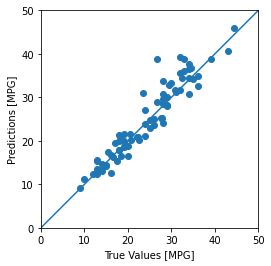

In [73]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, m.numpy().flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## 5. Model Interpretability with Shapley Values

- Using Open Source Library Shap - https://github.com/slundberg/shap
- Developed by Su-In Lee's lab at the University of Washington, and Microsoft Research

In [74]:
# adapted from https://github.com/kweinmeister/notebooks/blob/master/tensorflow-shap-college-debt.ipynb
# https://towardsdatascience.com/understand-how-your-tensorflow-model-is-making-predictions-d0b3c7e88500

In [ ]:
# ! pip install shap

In [75]:
import shap
shap.initjs()

### Train Model without Dense Features

In [76]:
def build_shap_model( num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[num_features]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [77]:
shap_num_features = len( numerical_feature_list)
shap_feature_columns =  tf_numerical_feature_list
#shap_feature_layer = tf.keras.layers.DenseFeatures(shap_feature_columns)
shap_model = build_shap_model( shap_num_features)

In [78]:
EPOCHS = 1000
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
shap_history = shap_model.fit( normed_train_data, train_labels,  callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Epoch 1/1000
10/10 [==============================] - 0s 8ms/step - loss: 568.3503 - mae: 22.6148 - mse: 568.3503
Epoch 2/1000


2022-06-17 13:52:30.226217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 5ms/step - loss: 512.6517 - mae: 21.3726 - mse: 512.6517
Epoch 3/1000
10/10 [==============================] - 0s 5ms/step - loss: 450.8770 - mae: 19.9370 - mse: 450.8770
Epoch 4/1000
10/10 [==============================] - 0s 5ms/step - loss: 381.6461 - mae: 18.2086 - mse: 381.6461
Epoch 5/1000
10/10 [==============================] - 0s 5ms/step - loss: 306.8260 - mae: 16.1583 - mse: 306.8260
Epoch 6/1000
10/10 [==============================] - 0s 5ms/step - loss: 232.3116 - mae: 13.8111 - mse: 232.3116
Epoch 7/1000
10/10 [==============================] - 0s 5ms/step - loss: 164.6028 - mae: 11.4458 - mse: 164.6028
Epoch 8/1000
10/10 [==============================] - 0s 5ms/step - loss: 108.7584 - mae: 9.1116 - mse: 108.7584
Epoch 9/1000
10/10 [==============================] - 0s 5ms/step - loss: 71.1169 - mae: 7.1768 - mse: 71.1169
Epoch 10/1000
10/10 [==============================] - 0s 5ms/step - loss: 50.9501 - mae: 5.8689 - mse: 5

Epoch 76/1000
10/10 [==============================] - 0s 5ms/step - loss: 7.0666 - mae: 1.9283 - mse: 7.0666
Epoch 77/1000
10/10 [==============================] - 0s 5ms/step - loss: 7.0641 - mae: 1.9552 - mse: 7.0641
Epoch 78/1000
10/10 [==============================] - 0s 5ms/step - loss: 6.9876 - mae: 1.9122 - mse: 6.9876
Epoch 79/1000
10/10 [==============================] - 0s 5ms/step - loss: 7.0196 - mae: 1.9346 - mse: 7.0196
Epoch 80/1000
10/10 [==============================] - 0s 5ms/step - loss: 7.1037 - mae: 1.9432 - mse: 7.1037
Epoch 81/1000
10/10 [==============================] - 0s 5ms/step - loss: 7.0529 - mae: 1.9076 - mse: 7.0529
Epoch 82/1000
10/10 [==============================] - 0s 5ms/step - loss: 6.9262 - mae: 1.9090 - mse: 6.9262
Epoch 83/1000
10/10 [==============================] - 0s 5ms/step - loss: 6.9855 - mae: 1.9052 - mse: 6.9855
Epoch 84/1000
10/10 [==============================] - 0s 5ms/step - loss: 7.0484 - mae: 1.9073 - mse: 7.0484
Epoch 85/1

### Use KMeans to Summarize Dataset

In [79]:
df_train_normed_summary = shap.kmeans(normed_train_data.values, 25)


In [80]:
# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(shap_model.predict, df_train_normed_summary)

1/1 [==============================] - 0s 26ms/step


2022-06-17 13:52:35.763760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [81]:
# `ipywidgets` may need to be installed to see status visualization.
# Please uncomment these two lines:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# And restart the kernel and run the notebook after installing the ipwidgets.
# From the top menu, click `Kernel` -> `Restart & Run All`

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [82]:
# Extract Shapley values from the explainer
shap_values = explainer.shap_values(normed_train_data.values)

  0%|          | 0/314 [00:00<?, ?it/s]

49/49 [==============================] - 0s 3ms/step


49/49 [==============================] - 0s 3ms/step


49/49 [==============================] - 0s 3ms/step


49/49 [==============================] - 0s 3ms/step


49/49 [==============================] - 0s 3ms/step


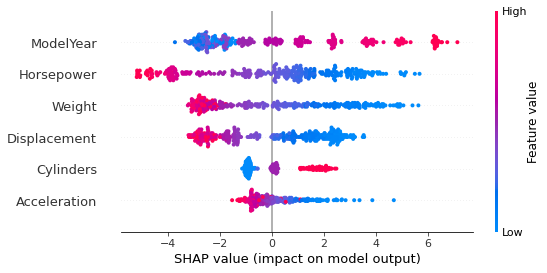

In [83]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], normed_train_data)

In [84]:
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], normed_train_data.iloc[INSTANCE_NUM,:])

In [85]:
# Plot the SHAP values for multiple instances
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], normed_train_data.iloc[0:NUM_ROWS])